In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet
from scipy.io import readsav
import scipy


starry.config.quiet = True
np.random.seed(1)

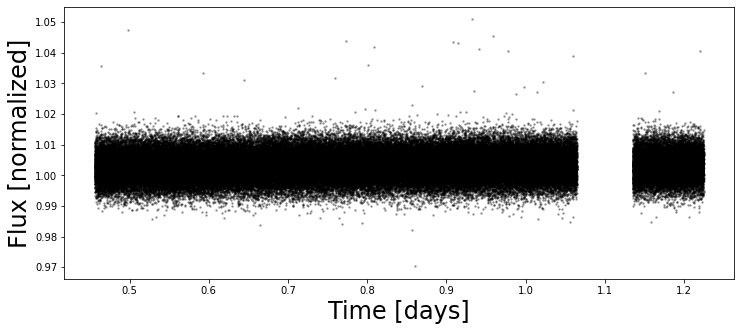

In [3]:
raw_data = readsav("drive/MyDrive/Planet At/phase_function_data_raw.sav")
t = raw_data['dt'].astype('float64')+1.1
flux = raw_data['fobs'].astype('float64')+1
ferr = 1e-4
'''
dt_binned = []
fobs_binned = []
binned_by = 50
for i in range(0,int(len(raw_data['dt'])/binned_by)):
    dt_binned.append(np.median(t[binned_by*i:(binned_by*i)+binned_by]))
    fobs_binned.append(np.median(flux[binned_by*i:(binned_by*i)+binned_by]))

'''
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
#plt.plot(t, flux_true)
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);
#plt.ylim(0.985,1.02)
plt.savefig('data_bin.png',dpi=300, bbox_inches='tight')

In [4]:
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    #offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)
    Y0 = pm.Normal("Y0", 0.5, 2.5, testval=0.5)
    Y1 = pm.Normal("Y1", 0.5, 2.5, testval=0.5)
    Y2 = pm.Normal("Y2", 0.5, 2.5, testval=0.5)
    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0, inc=90.0, obl=0.0), m=0.806, r=0.805, prot=1.0
    )
    A.map[1] = 0.4
    A.map[2] = 0.2

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** log_amp, inc=90.0, obl=0.0),
        m=1.162*9.5479*10**(-4),
        r=0.155313*	0.805,
        inc=85.71,
        prot=2.2,
        porb=2.2,
    )
    b.map[1, 0] = Y0
    b.map[1, 1] = Y1
    b.map[1, -1] = Y2
    b.theta0 = 180.0 
    
    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(t))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=ferr, observed=flux)


In [ ]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
optimizing logp for variables: [Y2, Y1, Y0, log_amp]


message: Desired error not necessarily achieved due to precision loss.
logp: -187251498.38345057 -> -126918339.88286997


In [ ]:
with model:
    trace = pmx.sample(
        tune=250,
        draws=500,
        start=map_soln,
        chains=4,
        cores=1,
        target_accept=0.9,
    )

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [Y2]
>Metropolis: [Y1]
>Metropolis: [Y0]
>Metropolis: [log_amp]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 371 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

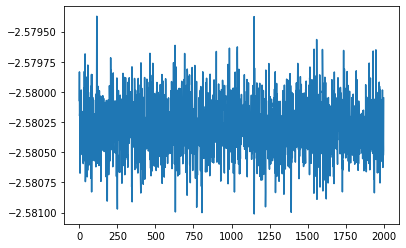

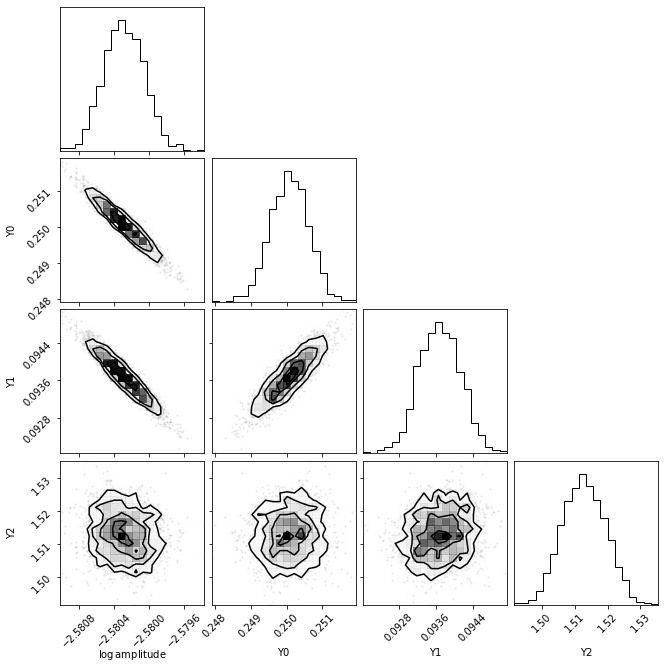

In [ ]:
import corner
import pandas as pd

#samples = pm.trace_to_dataframe(trace, varnames=["log_amp", "Y0", "Y1", "Y2"])
#samples.to_csv('mcmc.csv')
samples = pd.read_csv('mcmc.csv')

lon_max = []
l=0
for i in range (0,601):
  rand = np.random.randint(0,1999)
  point = samples.iloc[rand]

  planet = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** point['log_amp'], inc=90.0, obl=0.0),
        m=1.162*9.5479*10**(-4),
        r=0.155313*	0.805,
        inc=85.71,
        prot=2.2,
        porb=2.2,
    )

  planet.map[1, 0] = point['Y0']
  planet.map[1, 1] = point['Y1']
  planet.map[1, 2] = point['Y2']

  planet.theta0 = 180.0 
  #lat_list = np.arange(-180,180,1)
  lon_list = np.arange(-180,180,0.01)
  
  I = planet.map.intensity(lat=0, lon=lon_list).eval()
  l=l+1
  #print (lon_list[np.argmax(I)])
  #I.append(np.trapz(inte,x=lat_list))
  lon_max.append(lon_list[np.argmax(I)])

np.save('lon_max.npy',lon_max)
plt.plot(samples['log_amp'])
corner.corner(
    np.array(samples.iloc[:,1:]),
    labels=[r"$\log\,\mathrm{amplitude}$", r"Y0", r"Y1", r"Y2"],
);

In [ ]:
#samples = map_soln
planet = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, amp=10 ** np.median(samples['log_amp']), inc=90.0, obl=0.0),
        m=1.162*9.5479*10**(-4),
        r=0.155313*	0.805,
        inc=85.71,
        prot=2.2,
        porb=2.2,
    )

planet.map[1, 0] = np.median(samples['Y0'])
planet.map[1, 1] = np.median(samples['Y1'])
planet.map[1, 2] = np.median(samples['Y2'])

planet.theta0 = 180.0 
print (np.median(samples['log_amp']),np.median(samples['Y0']),np.median(samples['Y1']),np.median(samples['Y2']))
print (3*np.std(samples['log_amp']),3*np.std(samples['Y0']),3*np.std(samples['Y1']),3*np.std(samples['Y2']))

-2.5802898576563673 0.2500879626645403 0.0936892526539075 1.5127128321587096
0.0006909227919927604 0.0016215346742003197 0.0013363480543458028 0.019462193864878692


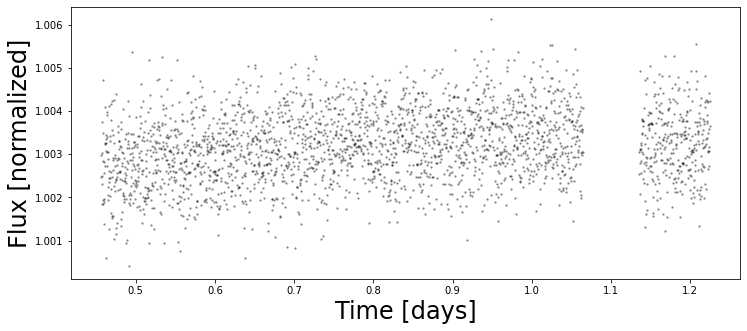

In [6]:
dt_binned = []
fobs_binned = []
binned_by = 50
for i in range(0,int(len(raw_data['dt'])/binned_by)):
    dt_binned.append(np.median(t[binned_by*i:(binned_by*i)+binned_by]))
    fobs_binned.append(np.median(flux[binned_by*i:(binned_by*i)+binned_by]))

plt.figure(figsize=(12, 5))
plt.plot(dt_binned, fobs_binned, "k.", alpha=0.3, ms=3)
#plt.plot(t, flux_true,'-b')
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);
#plt.ylim(0.999,1.007)
plt.savefig('model_bin.png',dpi=300, bbox_inches='tight')

In [ ]:
I = []
lat_list = np.arange(-180,180,1)
lon_list = np.arange(-180,190,1)
for lon in lon_list:
  inte = planet.map.intensity(lat=lat_list, lon=lon).eval()
  I.append(np.trapz(inte,x=lat_list))
#print (lon[np.argmax(I)])

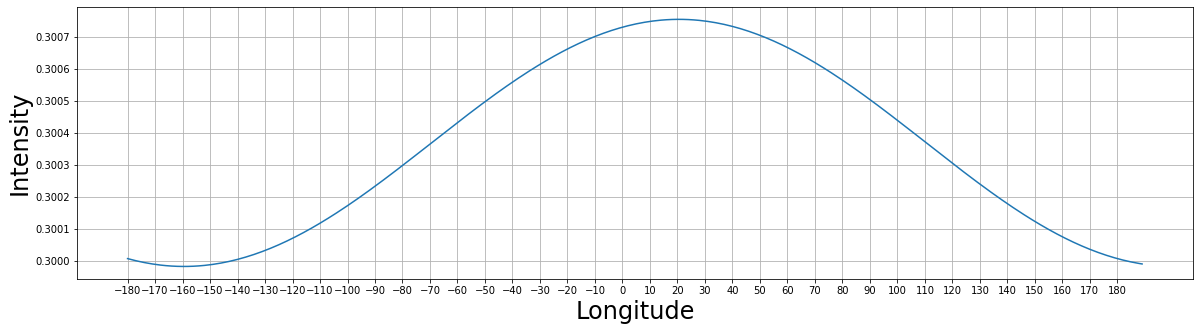

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(lon_list,I)
plt.xticks(np.arange(-180,190,10))
plt.grid(True)
plt.xlabel("Longitude", fontsize=24)
plt.ylabel("Intensity", fontsize=24);